## Running experiments with local resources Azure native logging

In this example, all the compute and storage are local, and we only use Azure to log the metrics from our experiments

In [1]:
import azureml.core
from azureml.core import Workspace

ws = Workspace.from_config()

print(f"Using {ws.name} with version {azureml.core.VERSION}")

Using azml-sdk with version 1.30.0


### Method 1: Running an experiment interactively from Jupyter

Read data into a Pandas DataFrame

In [2]:
import pandas as pd

df = pd.read_csv("data/diabetes.csv")
df.head()

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
0,1354778,0,171,80,34,23,43.509726,1.213191,21,0
1,1147438,8,92,93,47,36,21.240576,0.158365,23,0
2,1640031,7,115,47,52,35,41.511523,0.079019,23,0
3,1883350,9,103,78,25,304,29.582192,1.282870,43,1
4,1424119,1,85,59,27,35,42.604536,0.549542,22,0


In [3]:
cat_cols = ["Pregnancies"]
num_cols = ['PlasmaGlucose', 'DiastolicBloodPressure', 'TricepsThickness', 'SerumInsulin', 'BMI']

In [4]:
df[num_cols].describe().to_dict()

{'PlasmaGlucose': {'count': 10000.0,
  'mean': 107.8502,
  'std': 31.92090936056554,
  'min': 44.0,
  '25%': 84.0,
  '50%': 105.0,
  '75%': 129.0,
  'max': 192.0},
 'DiastolicBloodPressure': {'count': 10000.0,
  'mean': 71.2075,
  'std': 16.80147828964082,
  'min': 24.0,
  '25%': 58.0,
  '50%': 72.0,
  '75%': 85.0,
  'max': 117.0},
 'TricepsThickness': {'count': 10000.0,
  'mean': 28.8176,
  'std': 14.506480415228355,
  'min': 7.0,
  '25%': 15.0,
  '50%': 31.0,
  '75%': 41.0,
  'max': 92.0},
 'SerumInsulin': {'count': 10000.0,
  'mean': 139.2436,
  'std': 133.77791937465324,
  'min': 14.0,
  '25%': 39.0,
  '50%': 85.0,
  '75%': 197.0,
  'max': 796.0},
 'BMI': {'count': 10000.0,
  'mean': 31.567021743591003,
  'std': 9.804365693559133,
  'min': 18.20080735,
  '25%': 21.247426835,
  '50%': 31.922420785,
  '75%': 39.3289214475,
  'max': 56.03462763}}

Create or get the experiment, and then start a new run.

In [5]:
from azureml.core import Experiment

experiment = Experiment(workspace=ws, name="diabetes-local")
run = experiment.start_logging()
print(f"Starting experiment: {experiment.name}")

Starting experiment: diabetes-local


Log some basic metircs

In [6]:
row_count = df.shape[0]
run.log("observations", row_count)  # Log a number
run.log_list("data columns", df.columns)  # Log a list of strings
run.log_list("categorical columns", cat_cols)
run.log_list("numerical columns", num_cols)

The `log_row` method will keep appending to `stat` and `value` under the same column name

In [7]:
summary_stats = df[num_cols].describe().to_dict()
for col_name, stat_dict in summary_stats.items():
    for stat_name, val in stat_dict.items():
        run.log_row(col_name, stat=stat_name, value=val)  # Logging rows

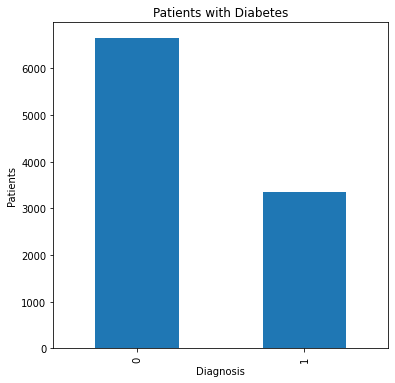

In [8]:
import matplotlib.pyplot as plt

diabetic_counts = df['Diabetic'].value_counts()

fig = plt.figure(figsize=(6,6))
ax = fig.gca()    
diabetic_counts.plot.bar(ax = ax) 
ax.set_title('Patients with Diabetes') 
ax.set_xlabel('Diagnosis') 
ax.set_ylabel('Patients')

run.log_image(name='label distribution', plot=fig)  # Log an image

In [9]:
df.sample(100).to_csv("sample.csv", index=False)
run.upload_file(name='outputs/sample.csv', path_or_stream='./sample.csv')

In [10]:
run.complete()

### Method 2: Running an experiment from a Python Script

This is very similar to running thins interactively. However, note the following:
- It uses the `Run.get_context()` method to retrieve the experiment run context when the script is run.
- It loads the diabetes data from the folder where the script is located.
- It creates a folder named **outputs** and writes the sample file to it - this folder is automatically uploaded to the experiment run

In [11]:
import os, shutil

# Setting up the folder for the experiment script
folder_name = "diabetes-local-experiment"
experiment_folder = './' + folder_name
os.makedirs(folder_name, exist_ok=True)

shutil.copy("data/diabetes.csv", os.path.join(folder_name, "diabetes.csv"))

'diabetes-local-experiment\\diabetes.csv'

Create a python script `diabetes_experiment.py` which runs the experiment. The folder `outputs` will b

In [12]:
%%writefile $folder_name/diabetes_experiment.py

from azureml.core import Run
import pandas as pd

df = pd.read_csv("diabetes.csv")

# This is the main difference from the interactive run from Jupyter
run = Run.get_context()

cat_cols = ["Pregnancies"]
num_cols = ['PlasmaGlucose', 'DiastolicBloodPressure', 'TricepsThickness', 'SerumInsulin', 'BMI']

# Log some basic metrics
row_count = df.shape[0]
run.log("observations", row_count)  # Log a number
run.log_list("data columns", df.columns)  # Log a list of strings
run.log_list("categorical columns", cat_cols)
run.log_list("numerical columns", num_cols)

# Log descriptive statistics
summary_stats = df[num_cols].describe().to_dict()
for col_name, stat_dict in summary_stats.items():
    for stat_name, val in stat_dict.items():
        run.log_row(col_name, stat=stat_name, value=val)  # Logging rows


# Log some image output
import matplotlib.pyplot as plt

diabetic_counts = df['Diabetic'].value_counts()

fig = plt.figure(figsize=(6,6))
ax = fig.gca()    
diabetic_counts.plot.bar(ax = ax) 
ax.set_title('Patients with Diabetes') 
ax.set_xlabel('Diagnosis') 
ax.set_ylabel('Patients')

run.log_image(name='label distribution', plot=fig)  # Log an image

# Log some file
os.makedirs("outputs", exist_ok=True)
df.sample(100).to_csv("outputs/sample.csv", index=False)

run.complete()

Overwriting diabetes-local-experiment/diabetes_experiment.py


Now you're almost ready to run the experiment. To run the script, you must create a `ScriptRunConfig` that identifies the Python script file to be run in the experiment, and then run an experiment based on it. We can also specify compute target and storage in this object. We'll go over those in detail later.

In [13]:
from azureml.core import Experiment, ScriptRunConfig, Environment
from azureml.core.conda_dependencies import CondaDependencies
from azureml.widgets import RunDetails

basic_env = Environment("pandas-env")
packages = CondaDependencies.create(
    pip_packages=["pandas"]
)
basic_env.python.conda_dependencies = packages
basic_env.python.user_managed_dependencies = True

script_config = ScriptRunConfig(
    source_directory=experiment_folder,
    script="diabetes_experiment.py",
    environment=basic_env
)

In [14]:
experiment = Experiment(workspace=ws, name="diabetes-local")
run = experiment.submit(config=script_config)
# Not sure why the widget view doesn't work...
# RunDetails(run).show()
run_details = run.wait_for_completion(show_output=True)

RunId: diabetes-local_1623215754_45eb5142
Web View: https://ml.azure.com/runs/diabetes-local_1623215754_45eb5142?wsid=/subscriptions/e6195ec1-51fe-4f2b-ba59-809f64544642/resourcegroups/azml-tutorials/workspaces/azml-sdk&tid=37e91b6c-3707-4f6c-96d4-48a1d2e55375

Streaming azureml-logs/60_control_log.txt

[2021-06-09T05:15:57.313082] Entering context manager injector.
[2021-06-09T05:15:58.757600] Using urllib.request Python 3.0 or later
Streaming log file azureml-logs/60_control_log.txt
Running: ['cmd.exe', '/c', 'C:\\Users\\hu_zh\\AppData\\Local\\Temp\\azureml_runs\\diabetes-local_1623215754_45eb5142\\azureml-environment-setup/conda_env_checker.bat']

Streaming azureml-logs/70_driver_log.txt

[2021-06-09T05:16:00.662030] Entering context manager injector.
[context_manager_injector.py] Command line Options: Namespace(inject=['ProjectPythonPath:context_managers.ProjectPythonPath', 'RunHistory:context_managers.RunHistory', 'TrackUserError:context_managers.TrackUserError'], invocation=['dia